## Семинар 4: "Сверточные сети"

ФИО: Фролов Михаил Алексеевич

In [110]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [111]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    for i in range(len(signal_convolved)):
        signal_convolved[i] = (signal[i:i+len(kernel)]*kernel[::-1]).sum()
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [112]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

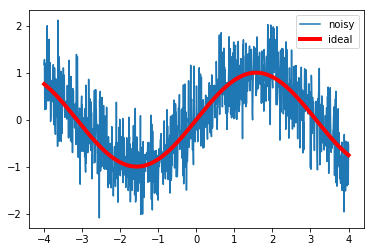

In [113]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [114]:
denoised_signal = t_convolve(noisy_signal, np.array([0.2,0.2,0.2,0.2,0.2]))

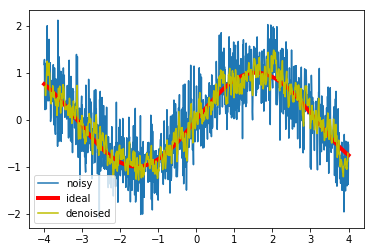

In [115]:
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

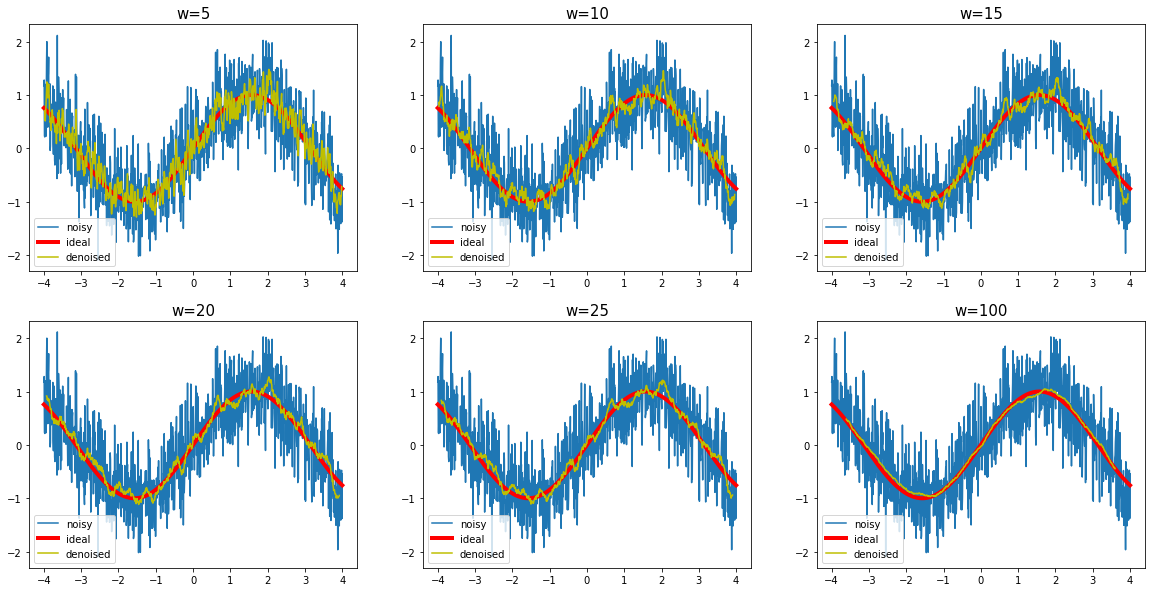

In [116]:
plt.figure(figsize=(20, 10))
for i, w in enumerate([5, 10, 15, 20, 25, 100]):
    plt.subplot(2, 3, i+1)
    kernel = np.array([1./w]*w)
    denoised_signal = t_convolve(noisy_signal, kernel)
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)
    plt.plot(x[(w-1)/2:-(w-1)/2], denoised_signal, 'y', label='denoised')
    plt.title('w={}'.format(w), fontsize=15)
    plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

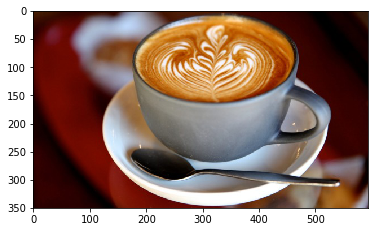

In [117]:
image = plt.imread('image.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [118]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])[None, None, :]

In [119]:
color_to_bw.shape, image.shape

((1, 1, 3), (350, 594, 3))

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

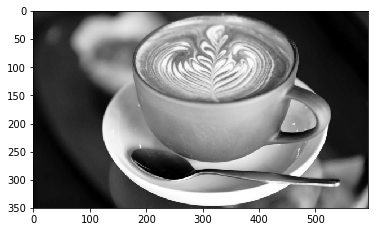

In [120]:
bw_image = convolve(image, color_to_bw[:, :, ::-1], mode='valid')[:, :, 0]
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [121]:
Kx = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
Ky = Kx.T
Gx = convolve(image, Kx[:, :, None], mode='valid').sum(2)
Gy = convolve(image, Ky[:, :, None], mode='valid').sum(2)

Text(0.5,1,u'|[Gx, Gy]|')

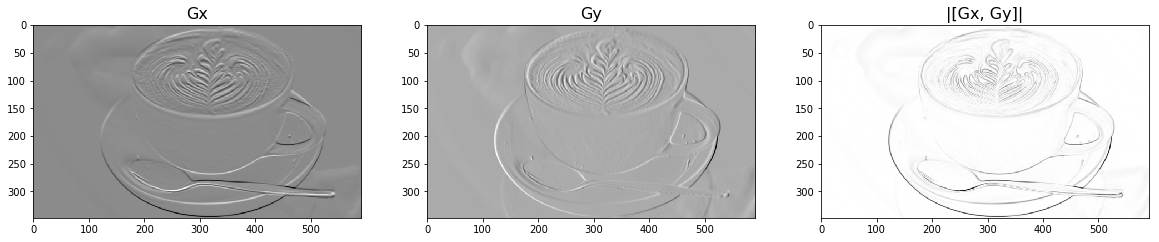

In [122]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(Gx, cmap=plt.cm.Greys)
plt.title('Gx', fontsize=16)
plt.subplot(1, 3, 2)
plt.imshow(Gy, cmap=plt.cm.Greys)
plt.title('Gy', fontsize=16)

edges = np.sqrt(Gx**2+Gy**2)
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap=plt.cm.Greys)
plt.title('|[Gx, Gy]|', fontsize=16)

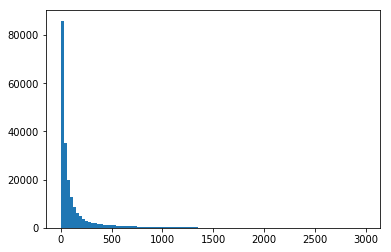

In [123]:
plt.hist(edges.ravel(), bins=100)
plt.show()

Text(0.5,1,u'TH=500')

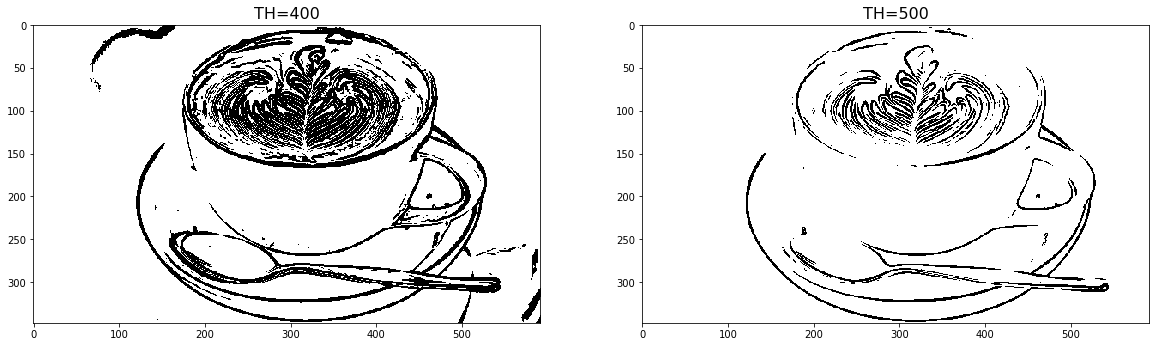

In [124]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges > 200, cmap=plt.cm.Greys)
plt.title('TH=400', fontsize=16)
plt.subplot(1, 2, 2)
plt.imshow(edges > 500, cmap=plt.cm.Greys)
plt.title('TH=500', fontsize=16)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [125]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    ##### YOUR CODE HERE #####
    shape = list(signal.shape)
    shape[-1] = kernel.shape[0]
    result = np.empty(shape)
    for i, k in enumerate(kernel):
        result[:,:,i] = convolve(signal, k, mode='valid')[:,:,0]
    return result.astype('uint8')

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [126]:
##### YOUR CODE HERE #####
kernel = [[[[1,0,0]]],
    [[[0,1,0]]],
    [[[0,0,1]]]
]
np_kernel = np.array(kernel)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

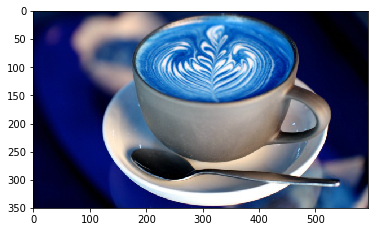

In [127]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))
bgr_image = t_convolve_bank(image, np_kernel)
plt.imshow(bgr_image)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [133]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    shape = list(image.shape)
    shape[0]//=2
    shape[1]//=2
    result = np.empty(shape)
    for height in range(image.shape[0]//2):
        for weight in range(image.shape[1]//2):
            for channel in range(image.shape[2]):
                result[height, weight, channel] = np.max(image[2*height:2*height+2, 2*weight:2*weight+2, channel])
    return result.astype('uint8')

def medianpool(image, w=2):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    shape = list(image.shape)
    shape[0]//=2
    shape[1]//=2
    result = np.empty(shape)
    for height in range(image.shape[0]//2):
        for weight in range(image.shape[1]//2):
            for channel in range(image.shape[2]):
                result[height, weight, channel] = np.mean(image[2*height:2*height+2, 2*weight:2*weight+2, channel])
    return result.astype('uint8')

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

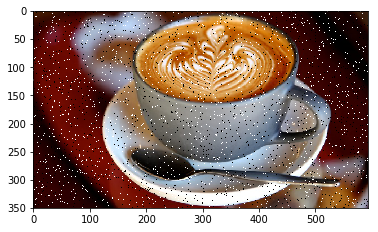

In [181]:
noise_white_y = np.random.randint(0, image.shape[0], 5000)
noise_white_x = np.random.randint(0, image.shape[1], 5000)
noise_black_y = np.random.randint(0, image.shape[0], 5000)
noise_black_x = np.random.randint(0, image.shape[1], 5000) 
sp_image = np.copy(image)
sp_image[noise_black_y, noise_black_x] = [0,0,0]
sp_image[noise_white_y, noise_white_x] = [255,255,255]
plt.imshow(sp_image)

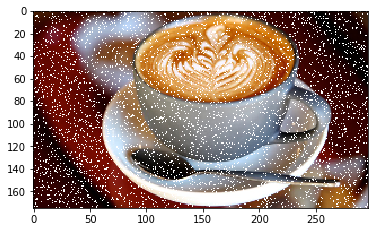

In [184]:
#Maxpool
maxpool_image = maxpool(sp_image)
plt.imshow(maxpool_image)

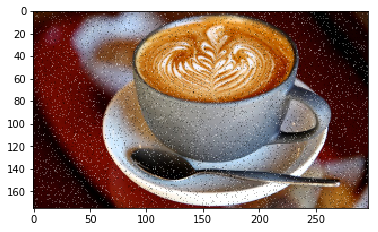

In [185]:
# Median pool
medianpool_image = medianpool(sp_image)
plt.imshow(medianpool_image)

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Maxpool убрал перец, но оставил соль. Medianpool убрал и соль и перец.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [186]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [194]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifierArchitecture1(nn.Module):
    def __init__(self):
        super(ConvClassifierArchitecture1, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(nn.Linear(14*14*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x
    
class ConvClassifierArchitecture2(nn.Module):
    def __init__(self):
        super(ConvClassifierArchitecture2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(nn.Linear(14*14*32, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [195]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.031/0.046	Accuracy: 0.991/0.985

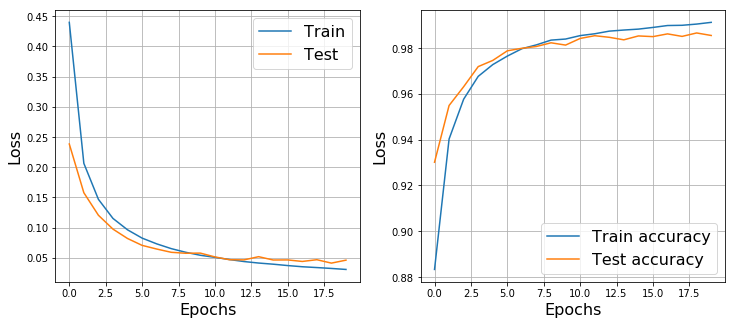

In [198]:
##### YOUR CODE HERE #####
network1 = ConvClassifierArchitecture1()
train(network1, 20, 1e-4)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.010/0.042	Accuracy: 0.997/0.989

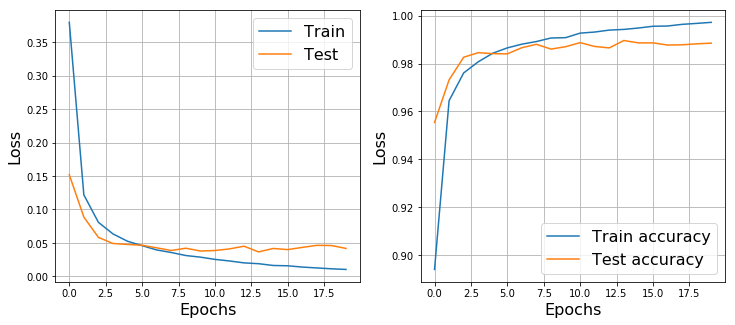

In [199]:
network2 = ConvClassifierArchitecture2()
train(network2, 20, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

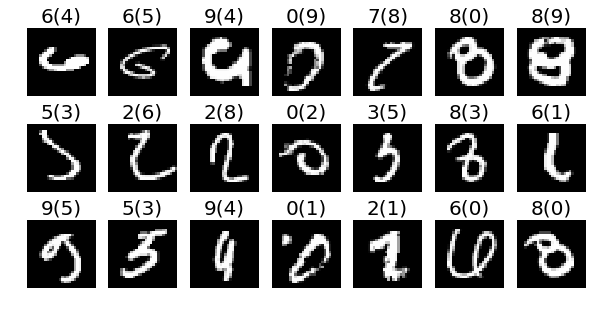

In [209]:
##### YOUR CODE HERE #####
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = Variable(X)
    y = Variable(y)
    prediction = network2(X).data.numpy()
    X = X.cpu().data.numpy()
    y = y.cpu().data.numpy()
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')


<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [210]:
##### YOUR CODE HERE #####
class ConvClassifierArchitecture3(nn.Module):
    def __init__(self):
        super(ConvClassifierArchitecture3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(nn.Linear(14*14*64, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.004/0.046	Accuracy: 0.999/0.990

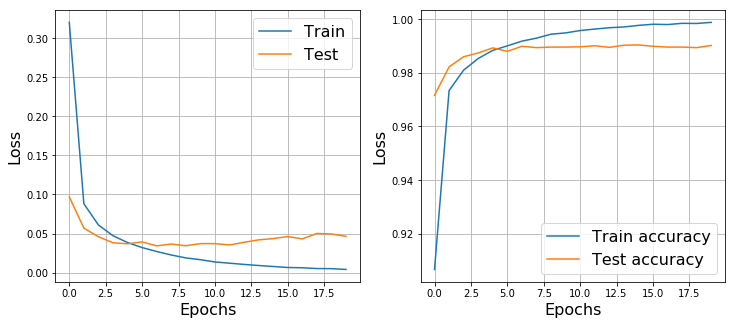

In [211]:
network3 = ConvClassifierArchitecture3()
train(network3, 20, 1e-4)

Таким образом, добавив ещё один сверточный слой, мы получили чуть лушее качество. Для улучшения результата нужно использовать оптимизаторы и dropout.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: